In [1]:
import torch
import torch.nn as nn
from torch import Tensor
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,SubsetRandomSampler,ConcatDataset
import torch.nn.functional as F

In [2]:
import sys
sys.path.insert(0, "/home1/smaruj/AkitaMini-pytorch")  # Add the directory where "ledidi" is located
from model import SeqNN
from helper import plot_map, from_upper_triu, upper_triangular_to_vector_skip_diagonals

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [4]:
model = SeqNN()

# Load the saved model weights
model.load_state_dict(torch.load('/home1/smaruj/AkitaMini-pytorch/best_model.pth'))

/tmp/SLURM_252247/ipykernel_943959/2425661507.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/home1/smaruj/AkitaMini-pytorch/best_mode

<All keys matched successfully>

In [5]:
model = model.to(device)

In [6]:
# Set the model to evaluation mode (important for inference)
model.eval()

SeqNN(
  (stochastic_reverse_complement): StochasticReverseComplement()
  (stochastic_shift): StochasticShift()
  (conv_block_1): ConvBlock(
    (conv): Conv1d(4, 96, kernel_size=(11,), stride=(1,), padding=(5,), bias=False)
    (batch_norm): BatchNorm1d(96, eps=0.001, momentum=0.0735, affine=True, track_running_stats=True)
    (pool): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_tower): ConvTower(
    (conv_tower): Sequential(
      (0): ReLU()
      (1): Conv1d(96, 96, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (2): BatchNorm1d(96, eps=0.001, momentum=0.0735, affine=True, track_running_stats=True)
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): ReLU()
      (5): Conv1d(96, 96, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (6): BatchNorm1d(96, eps=0.001, momentum=0.0735, affine=True, track_running_stats=True)
      (7): MaxPool1d(kernel_size=2, stride=2, padd

In [7]:
from torchinfo import summary

summary(model, input_size=(2, 4, 32768), col_names=["output_size", "num_params"])

Layer (type:depth-idx)                   Output Shape              Param #
SeqNN                                    [2, 1, 1953]              --
├─StochasticReverseComplement: 1-1       [2, 4, 32768]             --
├─StochasticShift: 1-2                   [2, 4, 32768]             --
├─ConvBlock: 1-3                         [2, 96, 4096]             --
│    └─Conv1d: 2-1                       [2, 96, 32768]            4,224
│    └─BatchNorm1d: 2-2                  [2, 96, 32768]            192
│    └─MaxPool1d: 2-3                    [2, 96, 4096]             --
├─ConvTower: 1-4                         [2, 96, 64]               --
│    └─Sequential: 2-4                   [2, 96, 64]               --
│    │    └─ReLU: 3-1                    [2, 96, 4096]             --
│    │    └─Conv1d: 3-2                  [2, 96, 4096]             46,080
│    │    └─BatchNorm1d: 3-3             [2, 96, 4096]             192
│    │    └─MaxPool1d: 3-4               [2, 96, 2048]             --
│    │

In [8]:
X = torch.load("/scratch1/smaruj/ledidi_targets/X.pt", weights_only=True)

In [9]:
modified_vector_tensor = torch.load("/scratch1/smaruj/ledidi_targets/modified_vector.pt", weights_only=True)

In [ ]:
    # def get_affected_bins(self, changed_indices):
    #     """
    #     Determine which bins contain changed indices.
    #     Also include ±1 bin for safety.
    #     """
    #     slice_start, slice_end = changed_indices
    
    #     # Compute correct bin indices
    #     start_bin = slice_start // self.bin_size
    #     end_bin = slice_end // self.bin_size  # Ensure proper bin inclusion
        
    #     affected_bins = set(range(start_bin, end_bin + 1))  # Directly affected bins

    #     # Include ±1 neighboring bins
    #     if start_bin > 0:
    #         affected_bins.add(start_bin - 1)
    #     if end_bin < self.num_bins - 1:
    #         affected_bins.add(end_bin + 1)

    #     return sorted(affected_bins)  # Ensure ordered output

In [10]:
# to ensure the local, forked ledidi is used
# not the one installed using pip

import sys
sys.path.insert(0, "/home1/smaruj/ledidi")  # Add the directory where "ledidi" is located
from ledidi import Ledidi

In [ ]:
X.shape, modified_vector_tensor.shape

In [ ]:
X.dtype, modified_vector_tensor.dtype

In [ ]:
# wrapper = Ledidi(model, (1, 32768, 4), verbose=True, batch_size=1,
#                  input_loss=torch.nn.L1Loss(reduction='sum'), 
#                  output_loss=torch.nn.MSELoss(), # default losses
#                  max_iter=20000,
#                  early_stopping_iter=20000
#                  ).cuda()

In [11]:
start_index = 10752
end_index = 11264

In [12]:
seq_length = end_index - start_index

In [13]:
wrapper = Ledidi(model, verbose=True, batch_size=10,
                 tau=1.0, l=0.1, eps=1e-4, lr=1.0,
                 input_loss=torch.nn.L1Loss(reduction='sum'), 
                 output_loss=torch.nn.L1Loss(reduction='sum'),
                 max_iter=20000,
                 early_stopping_iter=2000,
                 slice_length=seq_length, 
                 slice_index=21,
                 use_semifreddo=True,
                 return_history=True
                 ).cuda()

Gradients enabled for weights: True
Model in train mode: False
Weights shape torch.Size([1, 4, 512])


In [14]:
slice_torch = X[:,:,start_index : end_index]

In [15]:
X_l_flank = X[:,:,start_index - 512*2 : start_index]
X_r_flank = X[:,:,end_index : end_index + 512*2]

In [16]:
# x_bar, history = wrapper.fit_transform(X, modified_vector_tensor)
# if use_semifreddo=True
# x_bar = wrapper.fit_transform(slice_torch, modified_vector_tensor, X_l_flank=X_l_flank, X_r_flank=X_r_flank)
x_bar, history = wrapper.fit_transform(slice_torch, modified_vector_tensor, X_l_flank=X_l_flank, X_r_flank=X_r_flank)

iter=I	input_loss=0.0	output_loss=79.8	total_loss=79.8	time=0.0
iter=100	input_loss=25.0	output_loss=74.36	total_loss=76.86	time=0.7239
iter=200	input_loss=13.3	output_loss=74.28	total_loss=75.61	time=0.6063
iter=300	input_loss=14.3	output_loss=74.29	total_loss=75.72	time=0.6089
iter=400	input_loss=14.6	output_loss=74.29	total_loss=75.75	time=0.6273
iter=500	input_loss=17.1	output_loss=74.23	total_loss=75.94	time=0.6266
iter=600	input_loss=14.2	output_loss=74.3	total_loss=75.72	time=0.6111
iter=700	input_loss=14.3	output_loss=74.26	total_loss=75.69	time=0.617
iter=800	input_loss=13.9	output_loss=74.29	total_loss=75.68	time=0.6143
iter=900	input_loss=14.3	output_loss=74.29	total_loss=75.72	time=0.6132
iter=1000	input_loss=14.5	output_loss=74.27	total_loss=75.72	time=0.6086
iter=1100	input_loss=14.7	output_loss=74.26	total_loss=75.73	time=0.61
iter=1200	input_loss=13.9	output_loss=74.26	total_loss=75.65	time=0.6256
iter=1300	input_loss=13.2	output_loss=74.35	total_loss=75.67	time=0.6141


In [ ]:
x_bar.shape

In [ ]:
# if use_semifreddo=False
# x_bar = wrapper.fit_transform(X, modified_vector_tensor, X_l_flank=X_l_flank, X_r_flank=X_r_flank)
# x_bar, history = wrapper.fit_transform(X, modified_vector_tensor, X_l_flank=X_l_flank, X_r_flank=X_r_flank)

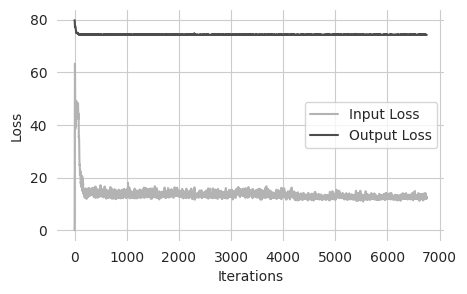

In [17]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

plt.figure(figsize=(5, 3))
plt.plot(history['input_loss'], c='0.7', label="Input Loss")
plt.plot(history['output_loss'], c='0.3', label="Output Loss")
plt.legend(fontsize=10)
plt.xlabel("Iterations")
plt.ylabel("Loss")

seaborn.despine(left=True, bottom=True)
plt.show()

In [18]:
X_new = X.clone()
X_new = X_new.repeat(10, 1, 1)

In [19]:
X_new[:,:,start_index:end_index] = x_bar

In [23]:
unique_set = set()

smallest_edited_location = 32000
biggest_edited_location = 0

for i in range(10):

    print("sequence:", i)
    
    difference_vector = (X[0, :, :] == X_new[i, :, :]).all(dim=0).cpu().numpy()

    e=0
    edits_loc = []

    for loc_index in range(len(difference_vector)):
        if difference_vector[loc_index] == False:
            e += 1
            edits_loc.append(loc_index)
            if loc_index < smallest_edited_location:
                smallest_edited_location = loc_index
            if loc_index > biggest_edited_location:
                biggest_edited_location = loc_index
    
    edits_tuple = tuple(edits_loc)

    if edits_tuple not in unique_set:
        unique_set.add(edits_tuple)
    
    print("number of edits:", e)
    print("edits locations:", edits_loc)

sequence: 0
number of edits: 12
edits locations: [10982, 10985, 10987, 10991, 10992, 11007, 11008, 11009, 11012, 11014, 11015, 11017]
sequence: 1
number of edits: 12
edits locations: [10982, 10985, 10987, 10991, 10992, 11007, 11008, 11009, 11012, 11014, 11015, 11017]
sequence: 2
number of edits: 12
edits locations: [10982, 10985, 10987, 10991, 10992, 11007, 11008, 11009, 11012, 11014, 11015, 11017]
sequence: 3
number of edits: 11
edits locations: [10985, 10987, 10991, 10992, 11007, 11008, 11009, 11012, 11014, 11015, 11017]
sequence: 4
number of edits: 11
edits locations: [10985, 10987, 10991, 10992, 11007, 11008, 11009, 11012, 11014, 11015, 11017]
sequence: 5
number of edits: 12
edits locations: [10982, 10985, 10987, 10991, 10992, 11007, 11008, 11009, 11012, 11014, 11015, 11017]
sequence: 6
number of edits: 12
edits locations: [10982, 10985, 10987, 10991, 10992, 11007, 11008, 11009, 11012, 11014, 11015, 11017]
sequence: 7
number of edits: 11
edits locations: [10985, 10987, 10991, 10992

In [21]:
len(unique_set)

2

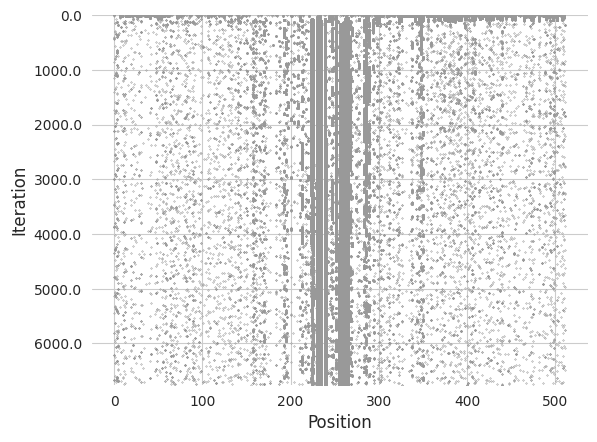

In [22]:
from ledidi.plot import plot_edits

plot_edits(history)
seaborn.despine(bottom=True, left=True)
plt.show()

In [25]:
import seaborn as sns
import numpy as np

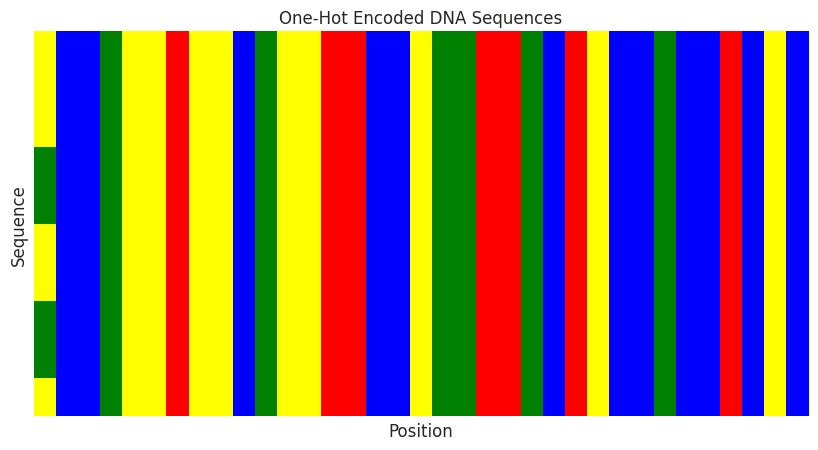

In [26]:
X_numpy = X_new.detach().cpu().numpy()
X_chunk = X_numpy[:, :, smallest_edited_location:biggest_edited_location]  # Shape: (10, 4, 200)

# Convert one-hot encoding to integer labels (0=A, 1=T, 2=C, 3=G)
sequence_labels = np.argmax(X_chunk, axis=1)  # Shape: (10, 200)

# Define a color map for nucleotides
nucleotide_cmap = {
    0: "green",  # A
    1: "blue",     # C
    2: "yellow",    # G
    3: "red"    # T
}

# Create a custom colormap for visualization
cmap = [nucleotide_cmap[i] for i in range(4)]
sns.set(style="white")

# Plot heatmap of all sequences
plt.figure(figsize=(10, 5))
sns.heatmap(sequence_labels, cmap=cmap, cbar=False, xticklabels=False, yticklabels=False)
plt.xlabel("Position")
plt.ylabel("Sequence")
plt.title("One-Hot Encoded DNA Sequences")
plt.show()

In [ ]:
# for i in range(10):

#     print("sequence:", i)
    
#     difference_vector = (x_bar[i,:,:] == X[0]).all(dim=0).cpu().numpy()

#     e=0
#     edits_loc = []

#     for loc_index in range(len(difference_vector)):
#         if difference_vector[loc_index] == False:
#             e += 1
#             edits_loc.append(loc_index)
            
#     print("number of edits:", e)
#     print("edits locations:", edits_loc)

In [ ]:
# for i in range(10):
#     print("sequence", i)
#     print("edits =", (X[0,:,:] != X_new[i,:,:]).sum() // 2)

In [ ]:
# for i in range(10):
#     print("sequence", i)
#     print("edits =", (x_bar[i,:,:] != X).sum() // 2)

In [27]:
# Get predictions
with torch.no_grad():
    # q_prediction = model(x_bar)
    q_prediction = model(X_new)

0


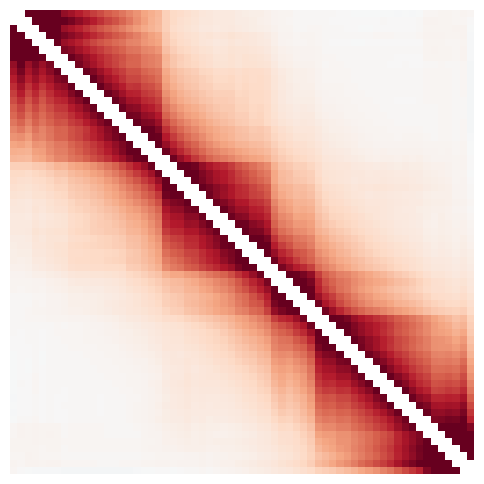

1


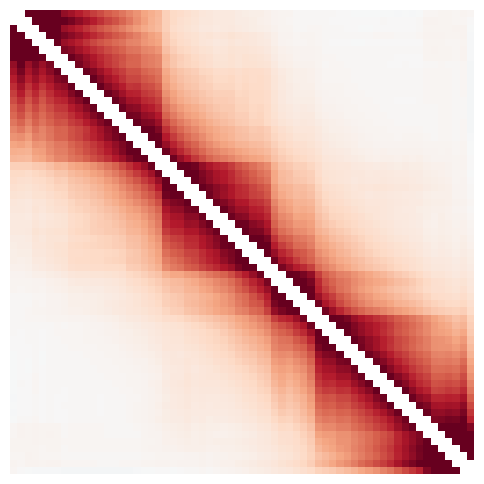

2


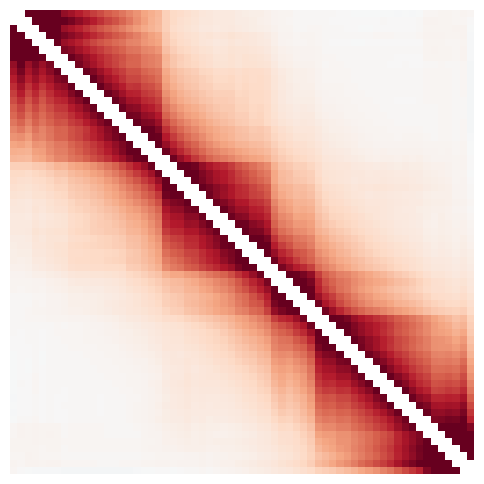

3


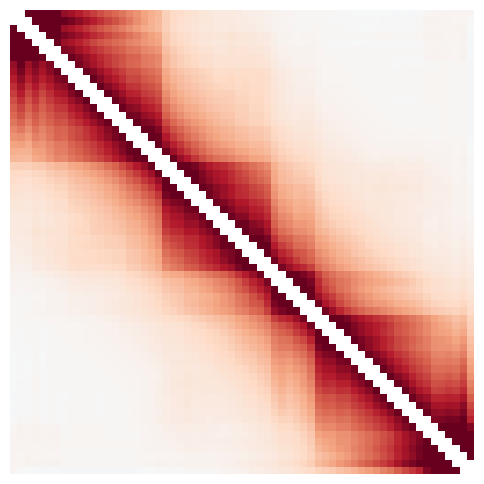

4


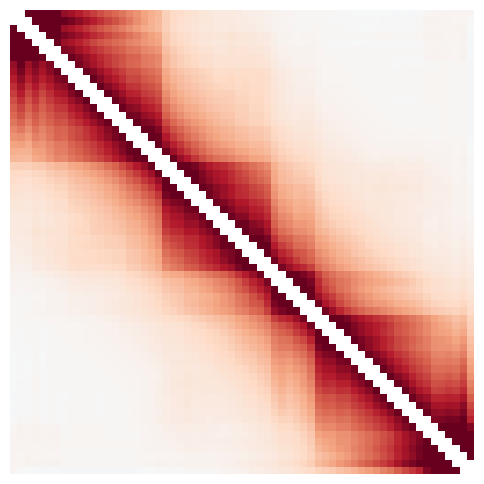

5


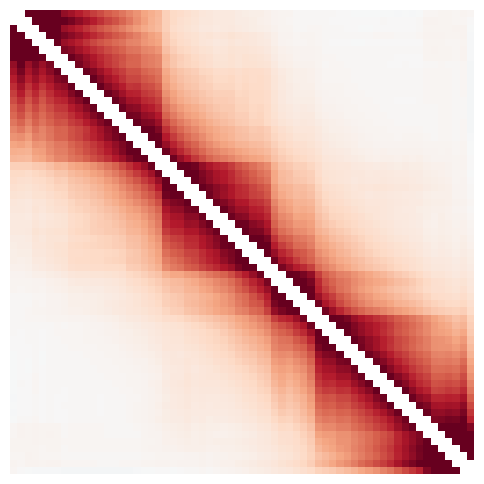

6


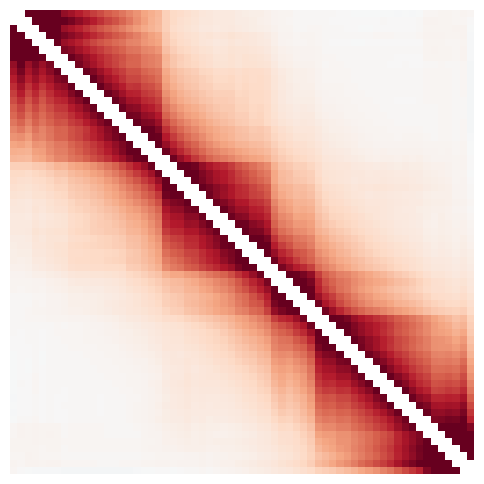

7


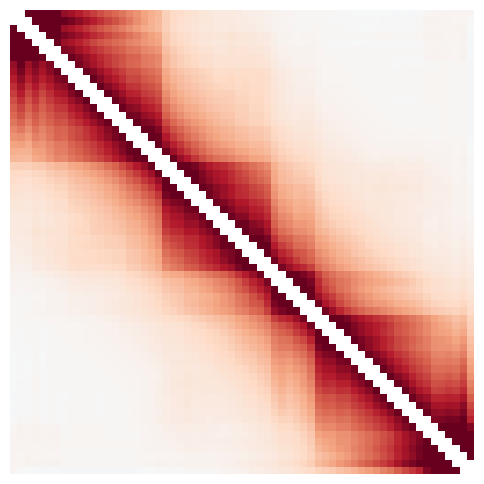

8


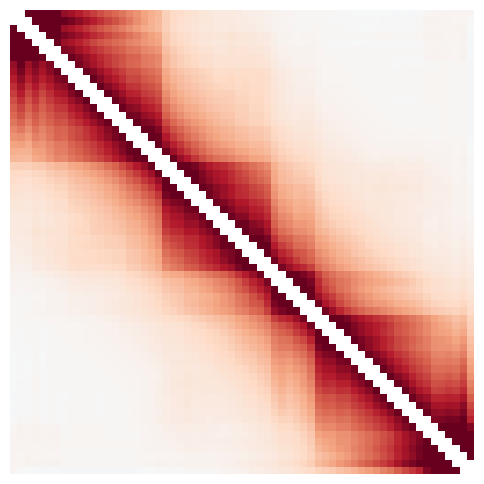

9


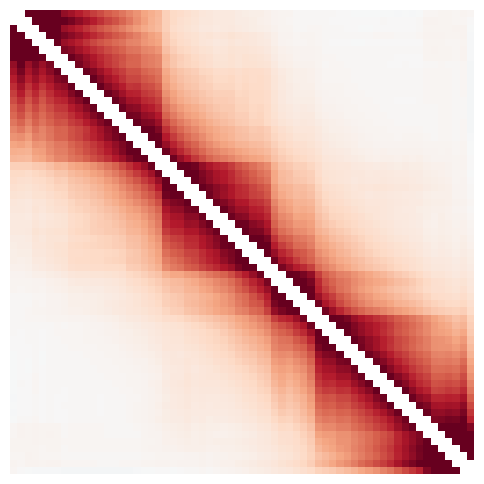

In [28]:
for i in range(10):
    print(i)
    plot_map(from_upper_triu(q_prediction[i], matrix_len=64, num_diags=2), vmin=-0.6, vmax=0.6, palette="RdBu_r", width=5, height=5)

## Plotting Memory Usage

In [ ]:
allocated_mb = torch.tensor([
    11.32,  # start
    11.43,  # after convblock
    11.32,  # after convtower
    11.37,  # after reading in the saved output
    11.37,  # after modifying the output
    11.44,  # after residual1d_block1
    11.47,  # after conv_reduce
    12.47,  # after one_to_two
    12.48,  # after concat_dist
    13.98,  # after conv2d_block
    13.98,  # after symmetrize_2d
    22.98,  # after residual2d_block4
    22.98,  # after cropping_2d
    23.36,   # after upper_tri
    23.01   # after final
])

reserved_mb = torch.tensor([
    54.00,  # start
    54.00,  # after convblock
    54.00,  # after convtower
    54.00,  # after reading in the saved output
    54.00,  # after modifying the output
    54.00,  # after residual1d_block1
    54.00,  # after conv_reduce
    54.00,  # after one_to_two
    54.00,  # after concat_dist
    54.00,  # after conv2d_block
    54.00,  # after symmetrize_2d
    66.00,  # after residual2d_block4
    66.00,  # after cropping_2d
    66.00,   # after upper_tri
    66.00   # after final
])


In [ ]:
import matplotlib.pyplot as plt

steps = [
    "start",
    "after convblock",
    "after convtower",
    "after reading in the saved output",
    "after modifying the output",
    "after residual1d_block1",
    "after conv_reduce",
    "after one_to_two",
    "after concat_dist",
    "after conv2d_block",
    "after symmetrize_2d",
    "after residual2d_block4",
    "after cropping_2d",
    "after upper_tri",
    "after final"
]

# Plot memory usage
plt.figure(figsize=(12, 6))
plt.plot(steps, allocated_mb, marker='o', label="Allocated Memory (MB)", linestyle='-')
plt.plot(steps, reserved_mb, marker='s', label="Reserved Memory (MB)", linestyle='--')

plt.xticks(rotation=45, ha="right")
plt.ylabel("Memory (MB)")
plt.xlabel("Forward Pass Steps")
plt.title("CUDA Memory Usage During Forward Pass")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Extract memory values
unified_steps = [
    "Start", "After ConvBlock 1", 
    "After ConvTower", "After Residual1D Block 1", "After ConvBlockReduce", 
    "After OneToTwo", "After ConcatDist2D", "After Conv2DBlock", "After Symmetrize2D", 
    "After Residual2D Block 4", "After Cropping2D", "After UpperTri", "After Final Layer"
]

full_allocated_memory = [16.59, 306.59, 411.32, 412.02, 412.34, 422.34, 
                    422.49, 437.49, 437.49, 527.49, 527.49, 531.26, 527.58]

full_reserved_memory = [126.00, 366.00, 448.00, 448.00, 448.00, 468.00, 
                   468.00, 468.00, 468.00, 580.00, 580.00, 580.00, 580.00]

semifreddo_allocated_mb = torch.tensor([
    11.32,  # start
    11.43,  # after convblock
    11.32,  # after convtower
    11.44,  # after residual1d_block1
    11.47,  # after conv_reduce
    12.47,  # after one_to_two
    12.48,  # after concat_dist
    13.98,  # after conv2d_block
    13.98,  # after symmetrize_2d
    22.98,  # after residual2d_block4
    22.98,  # after cropping_2d
    23.36,   # after upper_tri
    23.01   # after final
])

semifreddo_reserved_mb = torch.tensor([
    54.00,  # start
    54.00,  # after convblock
    54.00,  # after convtower
    54.00,  # after residual1d_block1
    54.00,  # after conv_reduce
    54.00,  # after one_to_two
    54.00,  # after concat_dist
    54.00,  # after conv2d_block
    54.00,  # after symmetrize_2d
    66.00,  # after residual2d_block4
    66.00,  # after cropping_2d
    66.00,   # after upper_tri
    66.00   # after final
])


# Plot memory usage
plt.figure(figsize=(12, 6))
plt.plot(unified_steps, full_allocated_memory, marker='o', label="FULL MODEL - Allocated Memory (MB)", linestyle='-')
plt.plot(unified_steps, full_reserved_memory, marker='s', label="FULL MODEL - Reserved Memory (MB)", linestyle='--')

plt.plot(unified_steps, semifreddo_allocated_mb, marker='^', label="SEMIFREDDO - Allocated Memory (MB)", linestyle=':')
plt.plot(unified_steps, semifreddo_reserved_mb, marker='d', label="SEMIFREDDO - Reserved Memory (MB)", linestyle='-.')

plt.xticks(rotation=45, ha="right")
plt.ylabel("Memory (MB)")
plt.xlabel("Forward Pass Steps")
plt.title("CUDA Memory Usage During Forward Pass")
plt.legend()
plt.grid(True)
plt.show()